### Imports

In [1]:
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

### Establish database connection

In [2]:
conn = psycopg2.connect(user = "admin",
                        password = "admin",
                        host = "localhost",
                        port = "5432",
                        database = "fakenews_100k")
cursor = conn.cursor()

### Proof that we have a working database

In [3]:
cursor.execute("SELECT count(*) FROM article")
count = cursor.fetchone()[0]
print "Database contains {} scraped articles".format(count)

Database contains 100000 scraped articles


#### We can associate an article with a label

In [4]:
cursor.execute("SELECT article.article_id, typ.type_name FROM article INNER JOIN typ ON article.type_id = typ.type_id")
res = cursor.fetchmany(10)

In [5]:
print "{:10}\t {:12}".format("article_id", "type_name")
print "------------------------------"
for row in res:
    print "{:10}\t {:>12}".format(row[0], row[1])

article_id	 type_name   
------------------------------
         2	        rumor
         6	         hate
         7	         hate
         8	         hate
         9	         hate
        10	         hate
        11	   unreliable
        13	   unreliable
        14	   unreliable
        15	   unreliable


# Fake News Corpus

## Basic Statistic

### Label Distribution

In [6]:
cursor.execute("select typ.type_name, count(article.type_id) from article inner join typ on typ.type_id = article.type_id group by typ.type_name")
res = cursor.fetchall()

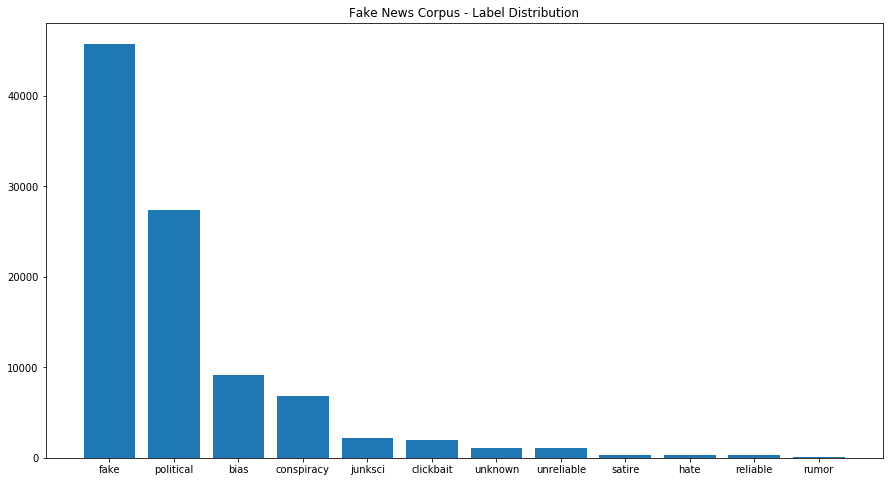

In [7]:
# Time to plot
res = sorted(res, key=lambda x: -x[1])

xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(xs, ys)
plt.xticks(xs, names)
plt.title("Fake News Corpus - Label Distribution")
plt.show()

### Author Distribution
I will perform this next exercise under the assumption that all author names makes sense and are not poorly scraped

In [18]:
query = """
    SELECT WA.author_name, COUNT(WA.article_id)
    FROM (SELECT A.author_name, A.author_id, W.article_id
          FROM author as A, written_by as W
           WHERE A.author_id = W.author_id) as WA
    GROUP BY WA.author_name
    ORDER BY COUNT(WA.article_id) DESC
"""
cursor.execute(query)
res = cursor.fetchall()

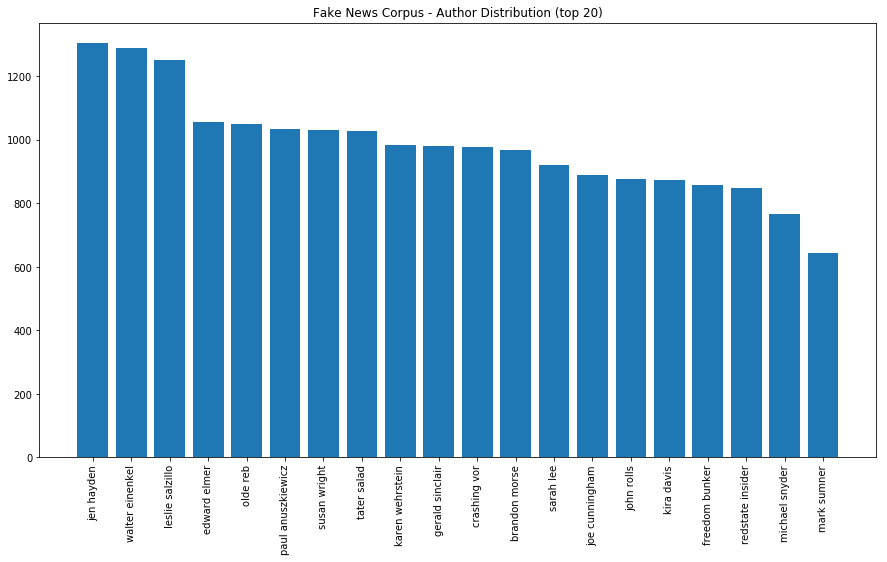

In [19]:
res = res[15:15+20] #first 15 make no sense
xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(xs, ys)
plt.xticks(xs, names, rotation='vertical')
plt.title("Fake News Corpus - Author Distribution (top 20)")
plt.show()

### Who's contributing to fake news

In [10]:
# type_id = 2 is fake news
query = """
    SELECT FK.author_name, COUNT(FK.type_id)
    FROM (SELECT A.author_name, A.author_id, W.article_id, AR.type_id
          FROM author as A, written_by as W, article as AR
          WHERE A.author_id = W.author_id
              AND W.article_id = AR.article_id
              AND AR.type_id = 2) as FK
    GROUP BY FK.author_name
    ORDER BY COUNT(FK.type_id) DESC
"""
cursor.execute(query)
res = cursor.fetchmany(20)

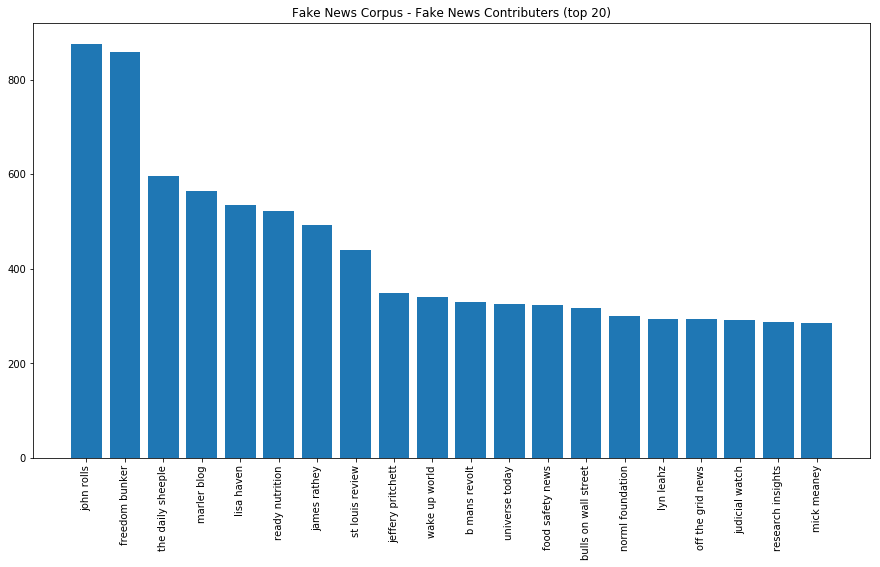

In [11]:
xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(xs, ys)
plt.xticks(xs, names, rotation='vertical')
plt.title("Fake News Corpus - Fake News Contributers (AUTHORS) (top 20)")
plt.show()

#### Webpages contributing to fake news

In [20]:
query = """SELECT WP.domain_url, COUNT(WP.domain_url) 
           FROM (SELECT A.article_id, D.domain_url 
                 FROM article as A, webpage as W, domain as D 
                 WHERE A.article_id = W.article_id 
                      AND W.domain_id = D.domain_id                                                                    
                      AND A.type_id = 2) as WP 
           GROUP BY WP.domain_url 
           ORDER BY COUNT(WP.domain_url) DESC"""
cursor.execute(query)
res = cursor.fetchmany(20)

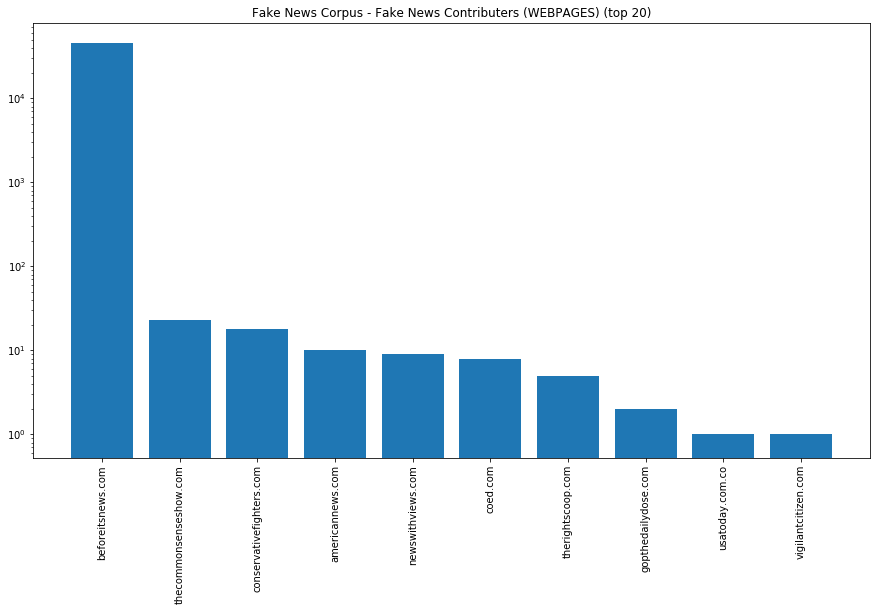

In [22]:
xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_yscale('log')
plt.bar(xs, ys)
plt.xticks(xs, names, rotation='vertical')
plt.title("Fake News Corpus - Fake News Contributers (WEBPAGES) (top 20)")
plt.show()

In [23]:
print "{} contributes to {} fake news articles.".format(names[0], ys[0])

beforeitsnews.com contributes to 45691 fake news articles.


Let's do NER on the articles from beforeitnews.com to perhaps get some insight into the motivation behind the fake news articles.

First we need to select the article from beforeitnews.com (Let's query all, not just fake news)

In [64]:
query = """
    SELECT A.content
    FROM article as A, webpage as W, domain as D
    WHERE A.article_id = W.article_id 
        AND W.domain_id = D.domain_id
        AND D.domain_url = '{}' """.format(names[0])
cursor.execute(query)
res = cursor.fetchmany(1000)

In [65]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

text = res

def process_doc(text):
    doc = nlp(unicode(text[0]))
    # set - dont spam plz
    items = set([x.text.lower() for x in doc.ents if x.label_ == "ORG" or x.label_ == "PERSON"])
    return items

rez = []
for t in text:
    rez += process_doc(t) # Fucking concat ;--)
   
freq = dict(Counter(rez))

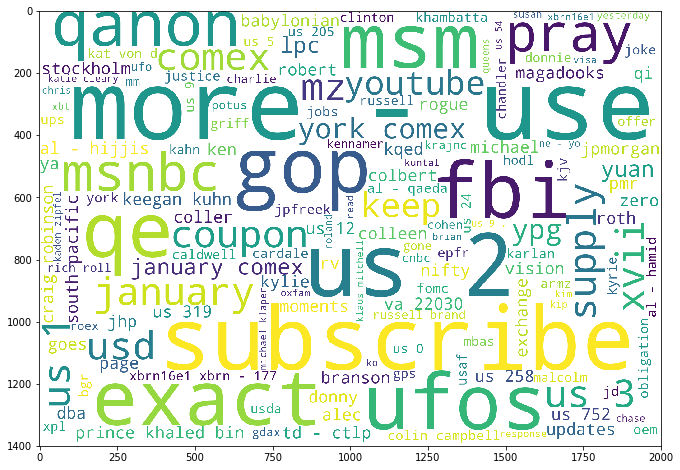

In [66]:
# Generate wordcloud
from wordcloud import WordCloud

wc = WordCloud(background_color="white",
               width=2000,
               height=1400, 
               max_words=500,
               relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(freq)

fig, ax = plt.subplots(figsize=(15, 8))
plt.imshow(wc)

In [61]:
print len(freq.keys())

14
